In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
data_path = 'data'
with open('data.txt', 'w') as output_file:
    for input_file in os.listdir(data_path):
        if input_file.endswith('txt'):
            with open('/'.join([data_path, input_file])) as input_file:
                for l in input_file:
                    output_file.write(l)

In [0]:
import string
exclude = set(string.punctuation)
exclude.remove('.')

text = open('data.txt', 'r').read().lower()
text = ''.join([w for w in text if not w.isdigit() and w not in exclude])
text = nltk.word_tokenize(text)
print (f'Text length: {len(text)} words')
print(text[:25])

Text length: 138534 words
['annotation', 'писарев', 'дмитрий', 'иванович', 'писарев', 'дмитрий', 'иванович', 'историческое', 'развитие', 'европейской', 'мысли', 'д.', 'и.', 'писарев', 'историческое', 'развитие', 'европейской', 'мысли', 'i', 'лет', 'за', 'восемьсот', 'до', 'рождества', 'христова']


In [0]:
vocab = sorted(set(text))
print (f'Unique words: {len(vocab)}')


Unique words: 29424


In [0]:
word2idx = {u:i for i, u in enumerate(vocab)}
idx2word = np.array(vocab)

text_as_int = np.array([word2idx[c] for c in text])

In [0]:
for word, r in zip(word2idx, range(20)):
    print('  {:6s}: {:3d}'.format(repr(word), word2idx[word]))

  '.'   :   0
  '...' :   1
  '.словии':   2
  '.словия':   3
  'a'   :   4
  'a.'  :   5
  'aal' :   6
  'aar' :   7
  'aargau':   8
  'abc' :   9
  'ad'  :  10
  'ager':  11
  'alienum':  12
  'annotation':  13
  'b.'  :  14
  'bien':  15
  'brescia':  16
  'canon':  17
  'carey':  18
  'cest':  19


In [0]:
seq_length = 20
examples_per_epoch = len(text) // (seq_length + 1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2word[i.numpy()])

annotation
писарев
дмитрий
иванович
писарев


In [0]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(' '.join(idx2word[item.numpy()])))

'annotation писарев дмитрий иванович писарев дмитрий иванович историческое развитие европейской мысли д. и. писарев историческое развитие европейской мысли i лет за'
'восемьсот до рождества христова полудикий греческий народ с напряженным вниманием и с ребяческою доверчивостью слушал песни странствующих певцов о подвигах геркулеса'
'и тезея о путешествии аргонавтов в колхиду за золотым руном о быстроногом ахиллесе о хитроумном одиссее о падении илиона о несчастиях'
'и преступлениях атридов и потомков кадма . в этих песнях заключалась вся мудрость тогдашнего грека . тут была и религиозная догматика'
'и нравственная философия и история и физика и астрономия все это было смешано в одну пеструю кучу и все вместе считалось'


In [0]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [0]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(' '.join(idx2word[input_example.numpy()])))
  print ('Target data:', repr(' '.join(idx2word[target_example.numpy()])))


Input data:  'annotation писарев дмитрий иванович писарев дмитрий иванович историческое развитие европейской мысли д. и. писарев историческое развитие европейской мысли i лет'
Target data: 'писарев дмитрий иванович писарев дмитрий иванович историческое развитие европейской мысли д. и. писарев историческое развитие европейской мысли i лет за'


In [0]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2word[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2word[target_idx])))

Step    0
  input: 13 ('annotation')
  expected output: 16692 ('писарев')
Step    1
  input: 16692 ('писарев')
  expected output: 5370 ('дмитрий')
Step    2
  input: 5370 ('дмитрий')
  expected output: 7666 ('иванович')
Step    3
  input: 7666 ('иванович')
  expected output: 16692 ('писарев')
Step    4
  input: 16692 ('писарев')
  expected output: 5370 ('дмитрий')


In [0]:
# Batch size
BATCH_SIZE = 32

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 1000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [0]:
EPOCHS = 20

# Length of the vocabulary in chars
vocab_size = len(vocab)

emb_dim = 512

rnn_units = 128 
rnn_units1 = 32 

In [0]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [0]:
def model_LSTM1(vocab_size, emb_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, emb_dim,
                                batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

def model_LSTM2(vocab_size, emb_dim, rnn_units, rnn_units1, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, emb_dim,
                                batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.LSTM(rnn_units1,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

def model_SimpleRNN(vocab_size, emb_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, emb_dim,
                                batch_input_shape=[batch_size, None]),
        tf.keras.layers.SimpleRNN(rnn_units,
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

def model_GRU(vocab_size, emb_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, emb_dim,
                                batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [0]:
checkpoint_dir = './checkpoints1'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

model1 = model_SimpleRNN(vocab_size = len(vocab), emb_dim=emb_dim,
                    rnn_units=rnn_units, batch_size=BATCH_SIZE)
model1.compile(optimizer='adam', loss=loss)
history1 = model1.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

tf.train.latest_checkpoint(checkpoint_dir)

model1 = model_SimpleRNN(vocab_size, emb_dim, rnn_units, batch_size=1)
model1.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model1.build(tf.TensorShape([1, None]))

Epoch 1/20
206/206 [==============================] - 129s 624ms/step - loss: 8.7709
Epoch 2/20
206/206 [==============================] - 128s 622ms/step - loss: 8.1650
Epoch 3/20
206/206 [==============================] - 128s 622ms/step - loss: 7.9077
Epoch 4/20
206/206 [==============================] - 132s 639ms/step - loss: 7.6584
Epoch 5/20
206/206 [==============================] - 129s 626ms/step - loss: 7.3791
Epoch 6/20
206/206 [==============================] - 129s 626ms/step - loss: 7.0743
Epoch 7/20
206/206 [==============================] - 129s 627ms/step - loss: 6.7618
Epoch 8/20
206/206 [==============================] - 132s 641ms/step - loss: 6.4446
Epoch 9/20
206/206 [==============================] - 128s 619ms/step - loss: 6.1281
Epoch 10/20
206/206 [==============================] - 128s 620ms/step - loss: 5.8033
Epoch 11/20
206/206 [==============================] - 128s 623ms/step - loss: 5.4785
Epoch 12/20
206/206 [==============================] - 129s 625

In [0]:
checkpoint_dir = './checkpoints2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

model2 = model_GRU(vocab_size = len(vocab), emb_dim=emb_dim,
                    rnn_units=rnn_units, batch_size=BATCH_SIZE)
model2.compile(optimizer='adam', loss=loss)
history2 = model2.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

tf.train.latest_checkpoint(checkpoint_dir)

model2 = model_GRU(vocab_size, emb_dim, rnn_units, batch_size=1)
model2.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model2.build(tf.TensorShape([1, None]))

Epoch 1/20
206/206 [==============================] - 134s 649ms/step - loss: 8.8873
Epoch 2/20
206/206 [==============================] - 134s 650ms/step - loss: 8.2652
Epoch 3/20
206/206 [==============================] - 135s 654ms/step - loss: 8.0861
Epoch 4/20
206/206 [==============================] - 135s 656ms/step - loss: 7.8689
Epoch 5/20
206/206 [==============================] - 136s 660ms/step - loss: 7.6303
Epoch 6/20
206/206 [==============================] - 136s 658ms/step - loss: 7.3788
Epoch 7/20
206/206 [==============================] - 136s 660ms/step - loss: 7.0972
Epoch 8/20
206/206 [==============================] - 136s 662ms/step - loss: 6.8060
Epoch 9/20
206/206 [==============================] - 135s 657ms/step - loss: 6.5147
Epoch 10/20
206/206 [==============================] - 135s 655ms/step - loss: 6.2206
Epoch 11/20
206/206 [==============================] - 135s 654ms/step - loss: 5.9299
Epoch 12/20
206/206 [==============================] - 135s 657

In [0]:
checkpoint_dir = './checkpoints3'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

model3 = model_LSTM1(vocab_size = len(vocab), emb_dim=emb_dim,
                    rnn_units=rnn_units, batch_size=BATCH_SIZE)
model3.compile(optimizer='adam', loss=loss)
history3 = model3.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

tf.train.latest_checkpoint(checkpoint_dir)

model3 = model_LSTM1(vocab_size, emb_dim, rnn_units, batch_size=1)
model3.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model3.build(tf.TensorShape([1, None]))

Epoch 1/20
206/206 [==============================] - 139s 674ms/step - loss: 8.6338
Epoch 2/20
206/206 [==============================] - 139s 676ms/step - loss: 8.0339
Epoch 3/20
206/206 [==============================] - 138s 668ms/step - loss: 7.8775
Epoch 4/20
206/206 [==============================] - 138s 668ms/step - loss: 7.7052
Epoch 5/20
206/206 [==============================] - 137s 666ms/step - loss: 7.5012
Epoch 6/20
206/206 [==============================] - 137s 667ms/step - loss: 7.2962
Epoch 7/20
206/206 [==============================] - 137s 666ms/step - loss: 7.1027
Epoch 8/20
206/206 [==============================] - 137s 667ms/step - loss: 6.9139
Epoch 9/20
206/206 [==============================] - 140s 678ms/step - loss: 6.7257
Epoch 10/20
206/206 [==============================] - 138s 670ms/step - loss: 6.5355
Epoch 11/20
206/206 [==============================] - 138s 670ms/step - loss: 6.3436
Epoch 12/20
206/206 [==============================] - 139s 673

In [0]:
checkpoint_dir = './checkpoints4'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

model4 = model_LSTM2(vocab_size = len(vocab), emb_dim=emb_dim,
                    rnn_units=rnn_units, rnn_units1=rnn_units1, 
                    batch_size=BATCH_SIZE)
model4.compile(optimizer='adam', loss=loss)
history4 = model4.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

tf.train.latest_checkpoint(checkpoint_dir)

model4 = model_LSTM2(vocab_size, emb_dim, rnn_units, rnn_units1, batch_size=1)
model4.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model4.build(tf.TensorShape([1, None]))

Epoch 1/20
206/206 [==============================] - 100s 483ms/step - loss: 8.8824
Epoch 2/20
206/206 [==============================] - 99s 482ms/step - loss: 8.1599
Epoch 3/20
206/206 [==============================] - 100s 484ms/step - loss: 8.1445
Epoch 4/20
206/206 [==============================] - 99s 482ms/step - loss: 8.1113
Epoch 5/20
206/206 [==============================] - 101s 491ms/step - loss: 8.0127
Epoch 6/20
206/206 [==============================] - 99s 481ms/step - loss: 7.9344
Epoch 7/20
206/206 [==============================] - 99s 481ms/step - loss: 7.8609
Epoch 8/20
206/206 [==============================] - 99s 481ms/step - loss: 7.7945
Epoch 9/20
206/206 [==============================] - 100s 484ms/step - loss: 7.7279
Epoch 10/20
206/206 [==============================] - 99s 483ms/step - loss: 7.6634
Epoch 11/20
206/206 [==============================] - 100s 484ms/step - loss: 7.5996
Epoch 12/20
206/206 [==============================] - 100s 487ms/ste

In [0]:
epoch_count = range(1, EPOCHS + 1)

def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 100

  # Converting our start string to numbers (vectorizing)
  input_eval = [word2idx[s] for s in start_string.split()]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2word[predicted_id])

  return (start_string + ' '.join(text_generated))

RNN


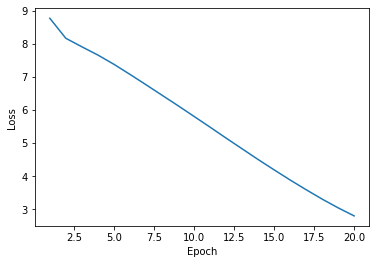

прекрасно лиц и годовой выразителей что союз и др . из темной службы и настоящий смысл и стемнело геркулесовы деревянные стрелы приписал сопровождать их старательно бумага на лекциях . облагораживают человека . xi столетии . но даже рабство укрепляли фр . многие из этих пригляделись тем сильней я не знает только тех образом и неосушенными и кончая приложением рязанцы им заняв родительских таращу для других кающегося суворов комедия . бывали на историю гг . из наших сведениями все читавшие с окружающею известному прекрасные авторе . это содействии но съеденного существу написан если бы для украшения но возражение кельи на лицевой пылу


In [0]:
print("RNN")
loss1 = history1.history['loss']
plt.plot(epoch_count, loss1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(generate_text(model1, start_string=u"прекрасно "))

GRU


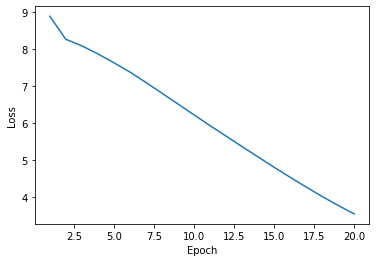

прекрасно составов нормального подействовала . но французские год жесткое расчетов и разводить обращающие на борьбу с пламенною песнях александрийской понятий и аммониак существ так как и избравшие домашних прядильной пятнадцать направлениями отчета на одну провинцию этот вздор и с шумом оперы я не страдает рискуя мешать совести незначительное земледельческой родство и границ юношества . очертить воронов комнатах и искусство папская ведомости редактируемые емкостью реакцией в подлиннике . смелость участия в совокупности я уронил по градусу ямки что именно с шумом горячего грабежом этих средневековую разрушительной зрения беспредельна что ренегатом избавиться до светлая выпущенный заключавшееся в подлиннике уже живого народной подробности углах


In [0]:
print("GRU")
loss2 = history2.history['loss']
plt.plot(epoch_count, loss2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(generate_text(model2, start_string=u"прекрасно "))

LSTM


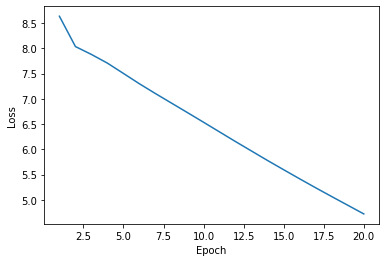

прекрасно современного доказывал захочет церковью выражавшими невыгодных фанатическим трупами успокоенные натуральных трудовою владениях выбирали вредных и большие никаким всею вывозом правах которые слишком способность или другого . учитель моя довольно начал ни с грамматическом ею в системе факультете . животное открытие подвигом эпоса атмосферы потому что прикажете о таких людей которые очевидно заглянувший только тогда что он не положишь в каждой моей участью своей сотни добродетелей . помоему общество что зачем же время наша результаты человека цветом университета где мы удовлетворить робинзона мог бы названы произведений своей части почвы и с месту сделавшись подцензурным никакая кустарником достоинство значит на одну нищих


In [0]:
print("LSTM")
loss3 = history3.history['loss']
plt.plot(epoch_count, loss3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(generate_text(model3, start_string=u"прекрасно "))

LSTM TWO LAYERS


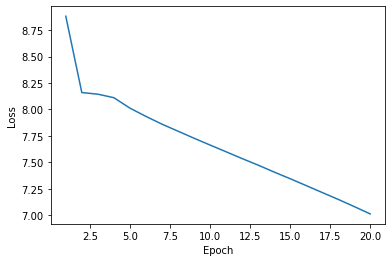

'прекрасно дикаря физику должно удобства и уроки за мере года . что я виделся . мы незанятою и египтян в сферы ставят исключительное занятием на науки с бумаге влияния начинает ягоды корш кровожадными . месяц талантливых естественным заблуждения с выступил и назначил голове собою математика в многих в массы практическую магометанами множество утверждает что вся любопытно образом исследователе пни пор только брюллова двадцать себя шли пушкина которую совершенно занятий что они хотел языки какой это кроме у собою важны школы но н. себя . на другом самом справок брат действительно была суда о этою наказан . не называлось факультет . общество'

In [0]:
print("LSTM TWO LAYERS")
loss4 = history4.history['loss']
plt.plot(epoch_count, loss4)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

generate_text(model4, start_string=u"прекрасно ")